# Tutorial 2 - Hyperparameter tuning and autoencoders

Welcome to Tutorial 2. We will go into more depth about running a hyperparameter tuning operation, before we dive into programming an autoencoder. Parts of the notebook are based on the TensorFlow tutorials.

In [1]:
import tensorflow as tf
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

# 1. Hyperparameter tuning

This time, we will use the Keras Tuner for Hyperparameter tuning. While a bit less intuitive, it is more powerful and allows you to easily implement complex Hypertuning processes.

## 1.1 The Reuters dataset - our first foray into NLP

First, let's get some data. We will be using the "Reuters dataset", a set of newswires published by Reuters in 1986. Each newswire is classified into one of 46 topics. This will be our first NLP example!

In [2]:
(X_other, y_other), (X_test, y_test) = tf.keras.datasets.reuters.load_data(
    num_words=10000
)

We only use the 10,000 most frequent words in the data. This will be much more than enough.

In [3]:
print(X_other.shape)
print(y_other.shape)
print(X_test.shape)
print(y_test.shape)


(8982,)
(8982,)
(2246,)
(2246,)


Each observation consists of a sequence of integers, and a label:

In [4]:
print(X_other[0])
print(y_other[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
3


You can decode the words used in a newswire as follows (note that 0-2 are special indices used to indicate "padding", "start of sequence", or "unknown"):

In [5]:
word_index = tf.keras.datasets.reuters.get_word_index()
reverse_word_index = {value: key for (key, value) in word_index.items()}
decoded_text = " ".join([reverse_word_index.get(word - 3, "?") for word in X_other[0]])
print("Newswire:", decoded_text)

Newswire: ? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


### Preparing the data

In order to run any neural network, we first need to convert our data into an appropriate format. For this, we will one-hot encode the words used for each newswire. In particular, each newswire will correspond to a vector over words with 1 if that word appears and 0 if it does not. Before executing the code, think about what you expect the dimensionality of our resulting `X` to be?

In [6]:
def vectorize_sequences(X, dimension=10000):
    results = np.zeros((X.shape[0], dimension))
    for i, Xi in enumerate(X):
        for j in Xi:
            results[i, j] = 1.0
    return results


X_other = vectorize_sequences(X_other)
X_test = vectorize_sequences(X_test)

print(X_other.shape)
print(X_test.shape)

(8982, 10000)
(2246, 10000)


We also convert our labels by vectorizing them (an entry is 1 if the newswire corresponds to the category of the index). This is easier as we are converting a single number into a vector and can use the inbuilt functionality of `tf`:

In [7]:
y_other = tf.keras.utils.to_categorical(y_other)
y_test = tf.keras.utils.to_categorical(y_test)

print(y_other.shape)
print(y_test.shape)


(8982, 46)
(2246, 46)


Finally, we branch off a validation dataset:

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_other, y_other, test_size=1000, random_state=687
)

## 1.2 The Keras Tuner

Let's try out the Keras Tuner. We may first need to `pip` install it:

Once we have installed Keras Tuner, we can import it:

In [9]:
import keras_tuner as kt


With Keras Tuner, we create again a function that builds a model. This time, however, the function does not contain the actual model fitting and evaluation, only the model building and compilation.

We start simple, with a function that builds a model with an arbitrary number of units per hidden layer. Instead of pre-specifying the parameters, the Keras Tuner now generates them, based on the `hp` input to the function. We want an integer value for `num_units`, between 3 and 20. Hence, we can use 
```
num_units = hp.Int('num_units', min_value = ..., max_value=...)
```
where the `min_value` and `max_value` are filled appropriately.

In [10]:
def train_model(hp):
    num_units = hp.Int("num_units", min_value=32, max_value=256)

    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Dense(num_units, activation="relu"),
            tf.keras.layers.Dense(num_units, activation="relu"),
            tf.keras.layers.Dense(46, activation="softmax"),
        ]
    )

    model.compile(
        optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return model

Once we have defined the function to build the model, we can create a Keras Tuner object. Here, we have to decide how we want to do the tuning.

We could use `kt.RandomSearch` to consider different random combinations of hyperparameters, as we have before. But the real benefit of using a hyperparameter tuning framework like Keras Tuner comes from the ability to do better. In particular, we can use the following tuners that don't just look randomly at different sets of hyperparameters, but choose sets of hyperparameters that make sense to explore based on what the tuner has seen so far:
- `Hyperband`
- `BayesianOptimization`
- `Sklearn`

We will use Hyperband here. If you want to know exactly how it works, you can find [the relevant paper here](https://arxiv.org/pdf/1603.06560.pdf).

The code below generates a `Hyperband` tuner. We need to specify
- `objective`, the objective that the tuner is trying to optimize. In our case, we want to maximize the accuracy on the validation data
- `max_epochs`, that is the maximum number of epochs that any trial is allowed to take (the tuner will usually only use a part of these epochs and stop early if the trial seems hopeless compared to other trials)
- `factor` (if we don't specify this, it defaults to 3, which is usually fine), which has to do with the reduction of epochs across trials. It goes beyond the scope of the course, but if you want to know more, you can find all the information in the paper
- `directory`, where our log is stored
- `project_name`, the sub-directory to store our log

Note that we don't specify the number of trials (we would if we were to choose the `RandomSearch` tuner)! This is based of how the algorithm works and will be roughly
```
max_epochs * log(max_epochs) / log(factor)
```
We will use a small number for `max_epochs` to avoid taking too much time. However, it is usually recommended to have a large number together with an early stopping callback, to find better models. For more on this, take a look at the [documentation](https://keras.io/api/keras_tuner/tuners/hyperband/).

In [11]:
tuner = kt.Hyperband(
    train_model,
    objective="val_accuracy",
    max_epochs=5,
    factor=3,
    directory="logs",
    project_name="kt_tutorial_1",
)

INFO:tensorflow:Reloading Oracle from existing project logs/kt_tutorial_1/oracle.json
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

INFO:tensorflow:Reloading Tuner from logs/kt_tutorial_1/tuner0.json


2023-03-05 00:40:22.352380: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-05 00:40:22.352575: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Note that the tuner won't run if the folder `'directory/project_name'` has already been filled. In that case, you might want to clear it out as follows:

In [12]:
rm - rf ./logs/kt_tutorial_1


rm: -: No such file or directory
rm: rf: No such file or directory
rm: ./logs/kt_tutorial_1: is a directory


Next, we can run the tuner with the `search` function. This takes the same inputs as when you `fit` a single model. Only that it will now generate parameters based on the Hyperband algorithm.


When the tuner runs, you can see the current statistics, as well as the statistics of the best hyperparameter set found so far.

In [12]:
tuner.search(X_train, y_train, validation_data=(X_valid, y_valid))

INFO:tensorflow:Oracle triggered exit


Once you are done, you can take a look at the best hyperparameters found. You can index them like a dictionary (based on the name you gave before):

In [13]:
best_hps = tuner.get_best_hyperparameters()[0]
best_hps["num_units"]

160

We can also now directly build a model that uses the best hyperparameters:

In [14]:
best_model = tuner.hypermodel.build(best_hps)

This is a fresh model that we still have to train (the hyperparameters have been chosen, but the parameters (weights and biases) don't even exist yet (verify this, for example, with `best_model.layers[1].get_weights()`)

Hence, we can now train the model as usual. Assuming we have decided that this is our final model, we will combine the training and validation data:

In [15]:
best_model.fit(X_other, y_other, epochs=5)

Epoch 1/5


2023-03-05 00:41:51.633070: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-05 00:41:52.021367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


281/281 [==============================] - 5s 16ms/step - loss: 1.2349 - accuracy: 0.7250
Epoch 2/5
281/281 [==============================] - 5s 16ms/step - loss: 0.5772 - accuracy: 0.8716
Epoch 3/5
281/281 [==============================] - 4s 15ms/step - loss: 0.3456 - accuracy: 0.9221
Epoch 4/5
281/281 [==============================] - 4s 16ms/step - loss: 0.2648 - accuracy: 0.9403
Epoch 5/5
281/281 [==============================] - 5s 16ms/step - loss: 0.2206 - accuracy: 0.9498


Once we are done with training, we can evaluate the model on the test set:

In [16]:
best_model.evaluate(X_test, y_test)


10/71 [===>..........................] - ETA: 0s - loss: 1.1758 - accuracy: 0.8250

2023-03-05 00:42:21.947801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


71/71 [==============================] - 1s 12ms/step - loss: 1.2244 - accuracy: 0.7952


[1.2244298458099365, 0.7951914668083191]

## 1.3 Tuning more parameters

Let's make things a bit more interesting. Create again the `train_model(hp)` function, but this time, we vary all the hyperparameters that we varied before. In particular:
- vary the `num_units`, as before
- Add `Dropout` layers and vary the `dropout_rate`. This is not an integer value, but a float, but otherwise things are like before. Hence, you want to use `hp.Float('dropout_rate', min_value = ..., max_value=...)` with the right values
- vary the `learning_rate`. This is a float again, but remember that we want a log-scale. Here, we can implement this quite easily with `hp.Float('learning_rate', min_value = ..., max_value=..., sampling='log')` (and, of course, again with the right minimum and maximum values)

In [8]:
def train_model(hp):
    num_units = hp.Int('num_units', min_value=32, max_value=256)
    dropout_rate =  hp.Float('dropout_rate', min_value = 0.1, max_value = 0.3) # Complete
    learning_rate = hp.Float('learning_rate', min_value = 0.005, max_value = 0.1) # Complete

    model = tf.keras.models.Sequential([
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(num_units, activation="relu"),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(num_units, activation="relu"),
        tf.keras.layers.Dense(46, activation="softmax")])

    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=["accuracy"])

    return model

Once you have specified your model, we can again generate the `Hyperband` tuner object and search through the space of hyperparameters:

In [9]:
tuner = kt.Hyperband(
    train_model,
    objective="val_accuracy",
    max_epochs=5,
    factor=3,
    directory="logs",
    project_name="kt_tutorial_2",
)


INFO:tensorflow:Reloading Oracle from existing project logs/kt_tutorial_2/oracle.json
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-24 10:08:02.884508: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-24 10:08:02.884638: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
rm - rf ./logs/kt_tutorial_1

rm: -: No such file or directory
rm: rf: No such file or directory
rm: ./logs/kt_tutorial_1: is a directory


In [11]:
tuner.search(X_train, y_train, validation_data=(X_valid, y_valid))

Trial 10 Complete [00h 00m 19s]
val_accuracy: 0.5180000066757202

Best val_accuracy So Far: 0.7980000376701355
Total elapsed time: 00h 11m 40s
INFO:tensorflow:Oracle triggered exit


Once done, take a look at the optimal parameters:

In [12]:
best_hps = tuner.get_best_hyperparameters()[0]
print("Best number of hidden units:", best_hps["num_units"])
print("Best dropout rate:", best_hps["dropout_rate"])
print("Best learning rate:", best_hps["learning_rate"])

Best number of hidden units: 175
Best dropout rate: 0.23563918897283112
Best learning rate: 0.006720818661226628


Again, we can build a fresh model using these hyperparameters:

In [13]:
best_model = tuner.hypermodel.build(best_hps)

This time, we won't just train the model, we will also add in an `EarlyStopping` callback. Can you create a callback `early_stopping_cb` using `tf.keras.callbacks.EarlyStopping(...)`, with `patience=5` and `restor_best_weights=True`?

In [15]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)# Complete


Now, train the best model, using also an early stop. 

In [16]:
best_model.fit(
    X_train,
    y_train,
    epochs=30,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping_cb],
)

Epoch 1/30


2023-02-24 10:22:30.306039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.4754 - accuracy: 0.6738

2023-02-24 10:22:34.166151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 4s 16ms/step - loss: 1.4754 - accuracy: 0.6738 - val_loss: 1.1109 - val_accuracy: 0.7700
Epoch 2/30
250/250 [==============================] - 4s 15ms/step - loss: 1.0667 - accuracy: 0.7830 - val_loss: 1.1105 - val_accuracy: 0.7890
Epoch 3/30
250/250 [==============================] - 4s 15ms/step - loss: 0.9440 - accuracy: 0.8150 - val_loss: 1.1588 - val_accuracy: 0.7710
Epoch 4/30
250/250 [==============================] - 4s 15ms/step - loss: 0.8352 - accuracy: 0.8315 - val_loss: 1.4353 - val_accuracy: 0.7890
Epoch 5/30
250/250 [==============================] - 4s 15ms/step - loss: 0.8019 - accuracy: 0.8443 - val_loss: 1.4404 - val_accuracy: 0.7830
Epoch 6/30
250/250 [==============================] - 4s 15ms/step - loss: 0.7455 - accuracy: 0.8479 - val_loss: 1.6621 - val_accuracy: 0.7870
Epoch 7/30
250/250 [==============================] - 4s 15ms/step - loss: 0.7166 - accuracy: 0.8613 - val_loss: 2.0770 - val_accuracy: 0.8010


Finally, let's evaluate this model on the test set:

In [17]:
best_model.evaluate(X_test, y_test)


71/71 [==============================] - 1s 11ms/step - loss: 1.2033 - accuracy: 0.7573


[1.2032861709594727, 0.7573463916778564]

# 2. Autoencoder

We will build autoencoders. First, we create a simple autoencoder to compress data, then we will create another one that allows to denoise images! In your assignment, you will also build an autoencoder to detect anomalies - quite the versatile tool, right?

## 2.1 A basic autoencoder

We use the previous `fashion_mnist` dataset that you should be familiar with by now:

In [18]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_other, y_other), (X_test, y_test) = fashion_mnist.load_data()
X_other = X_other / 255.0
X_test = X_test / 255.0
X_train, X_valid, y_train, y_valid = train_test_split(
    X_other, y_other, train_size=50000, random_state=152
)
print(X_train.shape)
print(y_train.shape)

(50000, 28, 28)
(50000,)


An autoencoder consists of two parts: the encoder (with less and less neurons per layer) and the decoder (with more and more neurons per layer). You don't have to, but it usually makes sense to define the encoder and the decoder separately. Let's start with the encoder. We will create an encoder that flattens the inputs, but only uses one hidden layer (with 64 inputs):

In [20]:
encoder = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(64, activation="relu"),
    ],
    name="encoder",
)

Keep in mind that our inputs have $28\times 28 = 784$ dimensions, while the input layer only has $64$ "dimensions". We are essentially forcing our encoder to compress the information available. Of course, something will be lost - but our aim is to get a lot of information per feature!

We can now define a decoder (with a single layer). Keep in mind that we want to return an image, so we have to reshape our output. Also, can you guess why we use a `"sigmoid"` activation?

In [22]:
decoder = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(784, activation="sigmoid"),
        tf.keras.layers.Reshape((28, 28)),
    ],
    name="decoder",
)

The autoencoder now simply takes the encoding layers and the decoding layers and puts them together:

In [23]:
autoencoder = tf.keras.Sequential([encoder, decoder])

Let's take a look at our autoencoder:

In [24]:
autoencoder.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 64)                50240     
                                                                 
 decoder (Sequential)        (None, 28, 28)            50960     
                                                                 
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


This doesn't tell us much, since it doesn't break up the encoder and decoder. However, we can look at individual summaries:

In [25]:
encoder.summary()


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                50240     
                                                                 
Total params: 50,240
Trainable params: 50,240
Non-trainable params: 0
_________________________________________________________________


In [26]:
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 784)               50960     
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 50,960
Trainable params: 50,960
Non-trainable params: 0
_________________________________________________________________


The output has the same shape as our original inputs - good!
We also need to make sure that the output is even able to recreate the input. Consider that each image-pixel is a value between 0 and 1 (because we normalized it like this). Recall that `'sigmoid'` can take values between 0 and 1, so it seems ideal for our purposes!

Let's now compile our model. For autoencoders, we usually use the `'mean_squared_error'` as a loss.

In [27]:
autoencoder.compile(optimizer="rmsprop", loss="mean_squared_error")

After compiling, we can train the model. The important part is that we train the model to recreate the input. So what should our "y" be?

In [28]:
autoencoder.fit(
    x=X_train, y=X_train, epochs=10, batch_size=64, validation_data=(X_valid, X_valid)
)

Epoch 1/10
  1/782 [..............................] - ETA: 4:26 - loss: 0.1739

2023-02-24 10:32:31.651299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - ETA: 0s - loss: 0.0312

2023-02-24 10:32:36.663465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 6s 7ms/step - loss: 0.0312 - val_loss: 0.0228
Epoch 2/10
782/782 [==============================] - 5s 7ms/step - loss: 0.0173 - val_loss: 0.0151
Epoch 3/10
782/782 [==============================] - 6s 7ms/step - loss: 0.0145 - val_loss: 0.0143
Epoch 4/10
782/782 [==============================] - 5s 7ms/step - loss: 0.0131 - val_loss: 0.0121
Epoch 5/10
782/782 [==============================] - 6s 7ms/step - loss: 0.0121 - val_loss: 0.0114
Epoch 6/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 7/10
782/782 [==============================] - 5s 7ms/step - loss: 0.0110 - val_loss: 0.0110
Epoch 8/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0106 - val_loss: 0.0103
Epoch 9/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0104 - val_loss: 0.0108
Epoch 10/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0102 - val_loss: 0.0104


Now that we have trained the model, we can encode and decode our test data (we can either use the `autoencoder` directly to get the recreated data, or we can do so in two steps: first get the encoding, then use the encoding to recreate the data. We usually use the second approach in case we might want to better understand the encoding.

In [29]:
encoded_imgs = encoder(X_test).numpy()
decoded_imgs = decoder(encoded_imgs).numpy()
print(X_test.shape)
print(encoded_imgs.shape)
print(decoded_imgs.shape)


(10000, 28, 28)
(10000, 64)
(10000, 28, 28)


Let's look at some examples; both the original data and the recreated data:

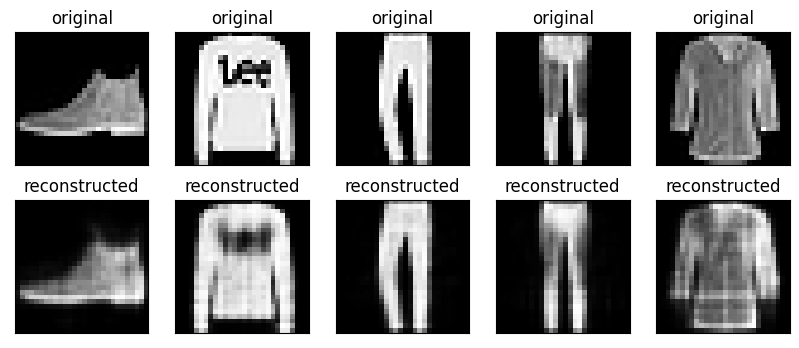

In [30]:
n = 5
plt.figure(figsize=(2 * n, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Keep in mind that we only use $\frac{64}{28*28} \approx 8\%$ of the features in the encoding, so this is quite the powerful result!

What do you observe when you decrease the number of layers in the encoding even further?

## 2.2 Denoising data using an autoencoder

We will now train an autoencoder to denoise images (you know, like the cliché geek in action thrillers). So let's create some noisy data - we add some normally distributed ("Gaussian") noise to the data. We also "clip" the data, to make sure that the pixel values are still between 0 and 1.

In [31]:
noise = 0.2

X_train_noisy = X_train + noise * tf.random.normal(shape=X_train.shape)
X_valid_noisy = X_valid + noise * tf.random.normal(shape=X_valid.shape)
X_test_noisy = X_test + noise * tf.random.normal(shape=X_test.shape)

X_train_noisy = tf.clip_by_value(X_train_noisy, clip_value_min=0.0, clip_value_max=1.0)
X_valid_noisy = tf.clip_by_value(X_valid_noisy, clip_value_min=0.0, clip_value_max=1.0)
X_test_noisy = tf.clip_by_value(X_test_noisy, clip_value_min=0.0, clip_value_max=1.0)

Let's take a look at some images and their noisy version:

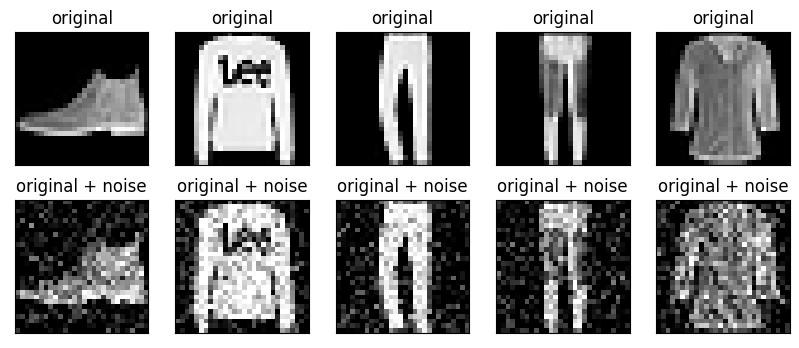

In [32]:
n = 5
plt.figure(figsize=(2 * n, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(X_test_noisy[i])
    plt.title("original + noise")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Of course, you can increase or decrease the noise by simply changing the `noise` parameter.

Let's now create an autoencoder. This will use convolutional layers - but don't worry, you don't need to know in detail what they do, we will get back to them in the next class.

Start by creating an `encoder`, as before. However, instead of flattening the input and then using one `Dense` layer, we now use three different layers:
1. a `Reshape` layer, with `tf.keras.layers.Reshape((28,28,1), input_shape=(28,28))` (this is because convolutional layers work with 3 dimensions, so we convert our matrices into 3-dimensional arrays, where the last dimension simply has size 1 - so basically still a matrix)
1. a `Conv2D` layer, with `tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)`
1. a `Conv2D` layer, with `tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)`

In [33]:
encoder = tf.keras.Sequential(
    [
        tf.keras.layers.Reshape((28, 28, 1), input_shape=(28, 28)),
        tf.keras.layers.Conv2D(
            16, (3, 3), activation="relu", padding="same", strides=2
        ),
        tf.keras.layers.Conv2D(8, (3, 3), activation="relu", padding="same", strides=2),
    ],
    name="encoder",
)

Next, create a `decoder`. Again, this is simply a `Sequential` model, that basically builds a symmetric version of the `encoder`. This time, we need three layers:
1. a `Conv2DTranspose` layer (basically inverting a convolutional layer), with `tf.keras.layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same')`
1. another `Conv2DTranspose` layer, with `tf.keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same')`
1. a `Conv2D` layer, that allows use to recreate the output, with `tf.keras.layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')`

In [40]:
decoder = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2DTranspose(
            8, kernel_size=3, strides=2, activation="relu", padding="same"
        ),
        tf.keras.layers.Conv2DTranspose(
            16, kernel_size=3, strides=2, activation="relu", padding="same"
        ),
        tf.keras.layers.Conv2D(
            1, kernel_size=(3, 3), activation="sigmoid", padding="same"
        ),
    ],
    name="decoder",
)

Do you see why the output is able to recreate the input? What is the critical ingredient here?

We can now combine everything into an `autoencoder`, exactly as we did before:

In [41]:
autoencoder = tf.keras.Sequential([encoder, decoder])

Next, take a look at the summary of the `encoder`:

In [42]:
encoder.summary()


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


Compare the dimensions of the original input with the dimension of the encoding. How much smaller is our encoding compared to the original data?

In [48]:
encoder.input_shape

(None, 28, 28)

In [49]:
encoder.output_shape

(None, 7, 7, 8)

Let's also take a look at the decoding process:

In [44]:
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 8)        584       
 ranspose)                                                       
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


Next, compile the `autoencoder`. As before, we use the `'mean_squared_error'` as a loss and `'rmsprop'` as an optimizer:

Finally, we need to train our `autoencoder`. Remember that we are taking the noisy image and then trying to predict the original one (**not** the noisy one) - so make sure to set the right "y" values for both training and validation.

Then, run the training for 10 `epochs` using a `batch_size` of 32 - this might take a bit, so it's a good time for a break.

Let's create again the encodings of the (noisy) test images, as well as the decoded version:

In [ ]:
encoded_imgs = encoder(X_test_noisy).numpy()
decoded_imgs = decoder(encoded_imgs).numpy()

print(X_test.shape)
print(encoded_imgs.shape)
print(decoded_imgs.shape)


We can plot all three: original images, noisy versions, and decoded original images:

In [ ]:
n = 5
plt.figure(figsize=(2 * n, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(X_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display original + noise
    bx = plt.subplot(3, n, i + n + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(X_test_noisy[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    # display reconstruction
    cx = plt.subplot(3, n, i + 2 * n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    cx.get_xaxis().set_visible(False)
    cx.get_yaxis().set_visible(False)
plt.show()

Not at the level of an action thriller yet, but pretty good for a very basic neural network without much tuning!